In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import itertools



from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sympy import *
from scipy.optimize import fsolve
from itertools import combinations
from scipy.stats import gmean, hmean
from pandas import Timestamp

In [2]:
borename = str(input())

1206


In [3]:
df = pd.read_excel('Z:2-UGIR\ONtrim\Нестеров С\Куюмбинское месторождение\Filter.xlsx', sheet_name=borename)

In [4]:
df = df.set_index('Дата')

In [5]:
df

,"Qж, м3/сут","Обв, %","Qн, т/сут","Qгаз, м3/сут","ГФ, м3/т","Рприем, атм"
Дата,,,,,,
2020-04-22,136,3,108.174,41647.14,498.000,135.8
2020-04-23,136,3,108.174,41647.14,498.000,134.9
2020-04-24,136,3,108.174,41647.14,498.000,134.3
2020-04-25,136,3,108.174,41647.14,498.000,132.9
2020-04-26,136,3,108.174,41647.14,498.000,132.3
...,...,...,...,...,...,...
2023-08-17,68,75,13.940,1711.99,122.811,81.2
2023-08-18,68,75,13.940,1711.99,122.811,83.4
2023-08-19,68,75,13.940,1711.99,122.811,81.8


In [6]:
p = np.array(df['Рприем, атм'])
po = 0.822 
gf = 157
B = 1.292

Ql = np.array(df['Qж, м3/сут'])
Qo = 1/po * np.array(df['Qн, т/сут'])
Qg = np.array(df['Qгаз, м3/сут'])
GF = np.array(df['ГФ, м3/т'])
W = np.array(df['Обв, %'])
Qgp = np.divide((Qg - Qo * gf), p)
Qw = Ql - Qo
Qow = np.array(B * Qo + Qw)
Qowg = np.array(Qow + Qgp)
Q = Qowg

date = df.index.tolist()
delta = np.array([(date[i] - date[0]).days for i in range(len(date))])
delta

array([   0,    1,    2, ..., 1214, 1215, 1216])

In [7]:
def logarithm_a(number):
    s = [Q[k] * np.log((delta[number + 1] - delta[k]) / (delta[number + 1] - delta[k + 1])) for k in
         range(number)]
    return sum(s)

In [8]:
def logarithm_b(band, number):
    s = [1/(4*np.pi*b_list[j]) * Q[k] * np.log((delta[number + 1] - delta[k]) / (delta[number + 1] - delta[k + 1])) 
         for j in range(band)
         for k in range(list_change[j], list_change[j + 1])]
    return sum(s)

In [9]:
def logarithm_c(band, number):
    s = [Q[k] * np.log((delta[number + 1] - delta[k]) / (delta[number + 1] - delta[k + 1])) 
         for k in range(list_change[band], number)]
    return sum(s)

In [48]:
def solution_a(list_num):
    a = Symbol('a')
    b = Symbol('b')
    w = Symbol('w')
    equation = [a - 1/(4*np.pi*b) * (logarithm_a(i - 1) + Q[i - 1] * (log(w) + np.log(delta[i] - delta[i - 1]))) - p[i]
        for i in list_num]
    solved_value = solve([simplify(equation[0]), simplify(equation[1]), simplify(equation[2])], [a, b, w])
    print(solved_value)
    if solved_value:
        return solved_value[0]

In [11]:
def solution_b(list_num, band):   
    b = Symbol('b')
    w = Symbol('w')
    
    equation = [a - logarithm_b(band, i - 1) - 1/(4*np.pi*b) * 
                (logarithm_c(band, i - 1) + Q[i - 1] * (log(w) + np.log(delta[i] - delta[i - 1]))) - p[i]
        for i in list_num]
    solved_value = solve([equation[0], equation[1]], [b, w])
    print(solved_value)
    if solved_value:
        return solved_value[0]

In [55]:
def solution_c(list_num, band):
    a = Symbol('a')
    b = Symbol('b')
    w = Symbol('w')
    
    equation = [a - logarithm_b(band, i - 1) - 1/(4*np.pi*b) * 
                (logarithm_c(band, i - 1) + Q[i - 1] * (log(w) + np.log(delta[i] - delta[i - 1]))) - p[i]
        for i in list_num]
    solved_value = solve([simplify(equation[2] - equation[0]), simplify(equation[2] - equation[0])], [b, w])
    print(equation[2] - equation[0])
    print(simplify(equation[2] - equation[1]))
    print(solved_value)
    if solved_value:
        return solved_value[0]

In [56]:
solution_c([1, 2, 3], 0)

2.0 - 0.0795774715459477*(330.690133343479*log(w) + 362.118648580851)/b + 26.1781314765128*log(w)/b
(1.40000000000001*b - 0.0553078267779199*log(w) - 10.6711884284273)/b
[(0.0686766000767795*log(w) + 14.4082432268498, w)]


(0.0686766000767795*log(w) + 14.4082432268498, w)

In [13]:
def plots(df_solution):
    for i in range(df_solution.shape[1]):
        plt.scatter(range(df_solution.shape[0]),
                df_solution.iloc[:, i], s=10)
        plt.grid()
        plt.show()

In [14]:
def standard(df):
    return pd.DataFrame(StandardScaler().fit_transform(df))

In [50]:
change = W
list_change = np.hstack([0, np.where(abs(change[:-1] - change[1:]) > 3)[0] + 1, df.shape[0] - 1])
list_change

array([   0,   20,   61,   77,   83,  223,  297,  442,  524,  927,  950,
       1024], dtype=int64)

In [453]:
change = GF
list_change = np.hstack([0, np.where(abs(change[:-1] - change[1:]) > 100)[0] + 1, df.shape[0] - 1])
list_change

In [16]:
change = p
list_change = np.hstack([0, np.where(change[:-1] - change[1:] < 0)[0] + 1, df.shape[0] - 1])

array([   0,    6,   14,   16,   27,   28,   32,   34,   36,   38,   43,
         46,   48,   49,   52,   55,   59,   62,   66,   68,   69,   73,
         76,   79,   86,   87,   89,   94,   95,   98,  100,  102,  107,
        108,  110,  113,  114,  115,  119,  120,  121,  122,  126,  128,
        130,  133,  136,  142,  147,  149,  150,  154,  156,  158,  162,
        164,  166,  168,  170,  171,  172,  174,  176,  177,  183,  191,
        194,  197,  205,  208,  210,  212,  215,  218,  220,  222,  226,
        229,  231,  236,  237,  239,  240,  243,  244,  247,  248,  251,
        253,  254,  257,  258,  260,  261,  263,  264,  267,  269,  270,
        271,  273,  275,  277,  279,  289,  294,  296,  298,  300,  304,
        316,  321,  322,  324,  330,  333,  335,  340,  341,  344,  347,
        349,  354,  355,  356,  358,  360,  369,  373,  375,  376,  378,
        379,  380,  382,  384,  386,  388,  390,  393,  397,  403,  405,
        407,  408,  410,  411,  415,  416,  418,  4

In [ ]:
chunks = np.array_split(range(21, 62), 3)
a = chunks[0]
b = chunks[1]
c = chunks[2]
list_combinations = list(itertools.product(a, b, c))

In [51]:
list_combinations = list(combinations(range(1, 21), 3)) 
list_combinations = [list(x) for x in list_combinations]
random.shuffle(list_combinations)
list_solution = []
n = int(input())
N = min(n, len(list_combinations))
print(N)
for j in range(N):
    list_solution.append(solution_a(list_combinations[j]))
list_solution = np.array(list(filter(lambda item: item is not None, list_solution)))

100
100
[(283.446167015462, 13.8939023068225, 7.71869009471709e+33)]
[(387.378625241719, 3062.68422155008, 2.51385469817997e+12828)]
[(447.478134215656, 100.468925812397, 1.54901590954969e+518)]
[(363.309229776636, 22.6241856337660, 1.24446580072849e+85)]
[(-466.140351957991, 2.89866402951336, 8.23557135623366e-30)]
[(331.139734417094, 24.4068394533946, 4.31572381791489e+78)]
[(311.631290132589, 17.6624609045153, 2.60830201747765e+51)]
[(517.667470508930, -27.4682370779265, 4.99384871832646e-175)]
[(373.539794993131, -17.3129005775838, 2.32186344213808e-70)]
[(418.269295960031, -49.0310652796899, 1.67873138710226e-231)]
[(414.794403216147, -56.8064231754275, 9.40578515319120e-265)]
[(238.274785954825, 6.28712131938218, 12312888314.5174)]
[(2877.55750639096, -1.46510404657668, 1.70027090362673e-67)]
[(98.6111817595972, 10.5836541487230, 2.83893558656716e-7)]
[(470.477232388274, 195.847280167853, 8.81318921575620e+1082)]
[(520.057392679427, -25.3269692076624, 1.63581345937843e-162)]
[(13

KeyboardInterrupt: 

In [505]:
df_solution = pd.DataFrame(list_solution)
df_solution = df_solution[(df_solution.iloc[:, 0] > 0) & (df_solution.iloc[:, 1] > 0)]

In [161]:
df_solution = pd.read_excel('Z:2-UGIR\ONtrim\Нестеров С\Куюмбинское месторождение\Solution.xlsx', sheet_name=borename)

In [160]:
with pd.ExcelWriter('Z:2-UGIR\ONtrim\Нестеров С\Куюмбинское месторождение\Solution.xlsx', mode="a", engine="openpyxl",if_sheet_exists="replace") as writer:
    df_solution.to_excel(writer, sheet_name=borename)

In [496]:
df_solution['Cluster'] = IsolationForest(n_estimators=1000, contamination=0.5).fit_predict(standard(df_solution))
df_solution = df_solution[df_solution['Cluster'] == 1]
df_solution.pop('Cluster')

1     1
3     1
4     1
5     1
6     1
7     1
8     1
9     1
14    1
18    1
20    1
21    1
22    1
23    1
25    1
26    1
29    1
31    1
32    1
33    1
34    1
36    1
38    1
39    1
40    1
41    1
49    1
50    1
52    1
56    1
57    1
59    1
60    1
61    1
64    1
65    1
66    1
67    1
71    1
72    1
75    1
76    1
81    1
83    1
93    1
98    1
99    1
Name: Cluster, dtype: int32

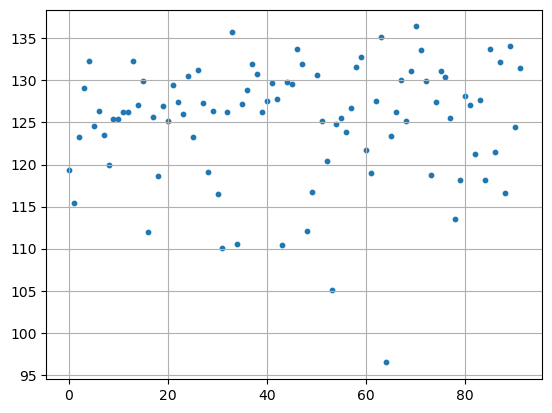

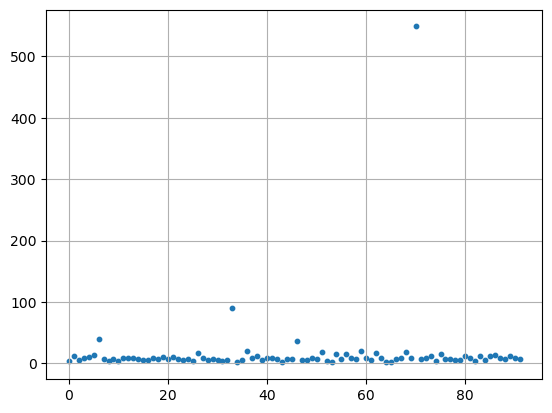

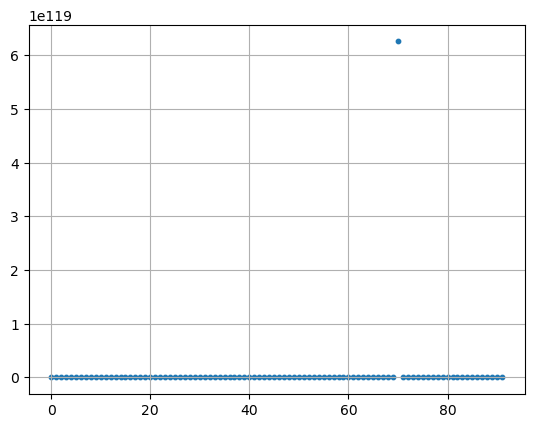

In [506]:
plots(df_solution)

In [507]:
df_solution.mean()

0     1.251417e+02
1     1.570898e+01
2    6.803093e+117
dtype: float64

In [47]:
b_list = []
c_list = []
for i in range(len(list_change) - 1):
    left = list_change[i]
    right = list_change[i + 1]
    list_combinations = list(combinations(range(left + 1, right + 1), 3)) 
    list_combinations = [list(x) for x in list_combinations]
    random.shuffle(list_combinations)
    list_solution_b = []
    n = 100
    N = min(n, len(list_combinations))
    print(N)
    for j in range(N):
         list_solution_b.append(solution_c(list_combinations[j], i))
    list_solution_b = np.array(list(filter(lambda item: item is not None, list_solution_b)))
    b_solution = pd.DataFrame(list_solution_b)
    b_solution = b_solution[(b_solution.iloc[:, 0] > 0) & (b_solution.iloc[:, 1] < 100)]
    try:
        b_solution['Cluster'] = IsolationForest(n_estimators=1000, contamination=0.5).fit_predict(standard(b_solution))
        b_solution = b_solution[b_solution['Cluster'] == 1]
        b_solution.pop('Cluster')
    except ValueError:
        pass
    plots(b_solution)
    b_list.append(b_solution.mean()[0])
    c_list.append(b_solution.mean()[1])
    print(b_solution.mean()[0], b_solution.mean()[1])

100
[(0.105270205747323*log(w) + 7.18573720984606, w)]
[(0.132170994003718*log(w) + 5.66304874822844, w)]
[(0.0754247785379283*log(w) + 4.13840774589681, w)]
[(0.117365693825651*log(w) + 18.3948789343704, w)]
[(0.0981986719249427*log(w) + 2.07626879013885, w)]
[(0.0994093424577412*log(w) + 3.62886274847218, w)]
[(0.105270205747323*log(w) + 7.18573720984606, w)]
[(0.105874156149177*log(w) + 3.05243097700441, w)]
[(0.0896641105556713*log(w) + 5.97910467982964, w)]
[(0.0873334562629409*log(w) + 5.49815514172762, w)]
[(0.0561175739161121*log(w) + 7.88282886898319, w)]
[(0.0797199524587556*log(w) + 1.52216007563552, w)]
[(0.120922398769359*log(w) + 7.10654975976357, w)]
[(0.0727233835487294*log(w) + 2.76739947682845, w)]
[(0.126393824119932*log(w) + 18.1319735144648, w)]
[(0.120922398769359*log(w) + 7.10654975976357, w)]
[(0.0700174323821856*log(w) + 11.5850882466373, w)]
[(0.105874156149177*log(w) + 3.05243097700441, w)]
[(0.0814238825088949*log(w) + 3.31584654183682, w)]
[(0.1040629499686

TypeError: cannot determine truth value of Relational

100
[(14.0368296326579, 11.3071862934129)]
[(-11.7730013213142, 0.00690397526008708)]
[(6.51287484818491, 1.94638977448873)]
[(3.53146659784091, 0.375405514785237)]
[(5.20520641520552, 0.690757366074139)]
[(5.62854236725317, 1.16797732464028)]
[(18.0637242280845, 34.4919673547457)]
[(6.29442363874577, 1.74269116717186)]
[(16.8842480479239, 23.0941488449223)]
[(6.78350178584578, 1.41271152688135)]
[(5.08060527242348, 0.665260111406886)]
[(12.4747357661725, 5.92539000195350)]
[(12.3139271213488, 5.73967980924638)]
[(-116.832926298487, 1.51816393176873e-27)]
[(-4.17025478747224, 0.00873736962842129)]
[(-0.385612329119170, 0.0593113561383397)]
[(6.64877625276327, 1.54192258999044)]
[(3.95524383136953, 0.473660488996494)]
[(19.0564574477994, 45.1954342106833)]
[(13.1357350522071, 6.75401115928541)]
[(15.5131716300989, 16.3742395425817)]
[(14.4069971158340, 12.5734296716863)]
[(16.7776262515280, 22.3468753744580)]
[(2.47988891509756, 0.210063551361870)]
[(17.2392187151988, 26.1138928173032)]

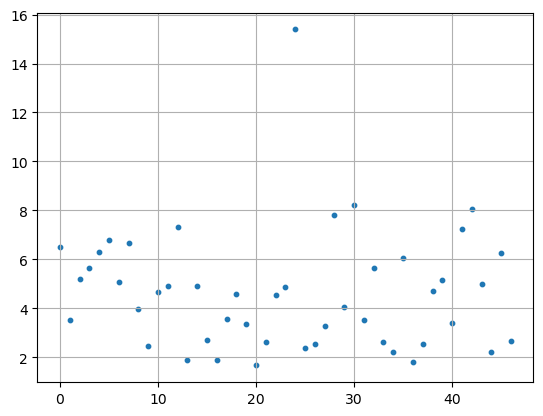

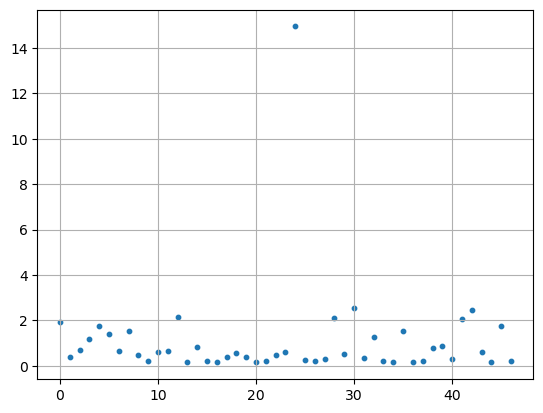

4.645531731058714 1.0997001254166028
100
[(-4.10698620497499, 0.0158987561653583)]
[(-2.50617936226993, 0.0138954466007162)]
[(3.63558666348964, 0.224251705594276)]
[(7.43257697587642, 1.63966236418001)]
[(6.50246772374514, 1.04865130433096)]
[(8.04323907187140, 2.00593977045179)]
[(0.573408450605637, 0.0365860146795562)]
[(-0.461961776213978, 0.0198187334996541)]
[(8.90885432182249, 5.50827814466710)]
[(5.66434236315945, 0.745449180595987)]
[(56.3029771961439, 1334308427.36490)]
[(5.59231465004435, 0.627837350821144)]
[(6.60808679699066, 0.808234347588409)]
[(2.75347851605228, 0.317476951562949)]
[(7.21179938177164, 1.54054027484574)]
[(10.7666213637270, 6.31265258322086)]
[(6.70250489899215, 1.17526620885391)]
[(6.41540296149983, 0.997893828258145)]
[(16.3114101849342, 155.253140689957)]
[(5.40372481990121, 0.637770396708091)]
[(8.93065072648066, 5.53475043333258)]
[(3.44650850833872, 0.186221433181966)]
[(-4.43088924745133, 0.00550979449004217)]
[(1.77515827230725, 0.228531252506563

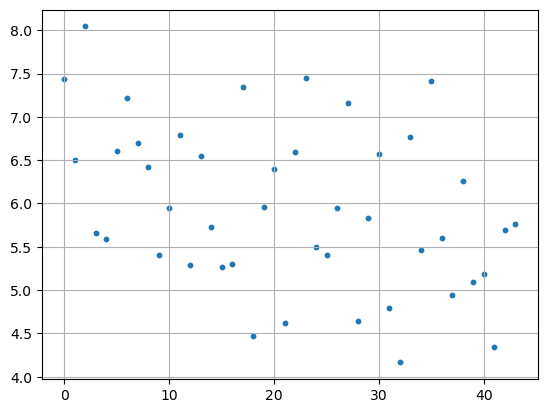

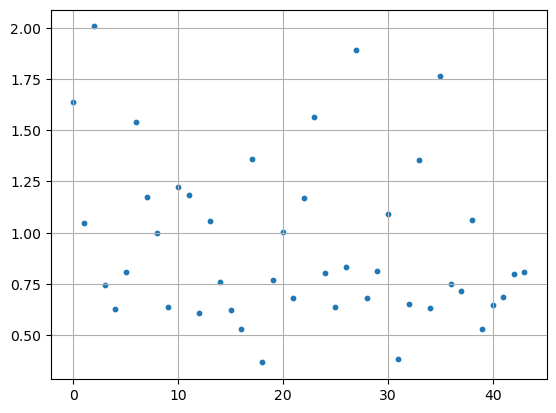

5.950376212318542 0.9469861551047032
100
[(6.43004095621931, 0.968420092497687)]
[(5.88123615891235, 0.868913524879705)]
[(5.65553744013070, 0.799733250138398)]
[(5.67746067240500, 0.789303110039838)]
[(11.2203184074041, 3.59889687352624)]
[(5.32285047666734, 0.729123281962294)]
[(4.85880798513337, 0.596694759619072)]
[(7.09505572732049, 0.999573341636029)]
[(5.55437668355417, 0.805809668581686)]
[(7.76353348874628, 1.10866041921774)]
[(5.97894506122954, 0.764112682710515)]
[(5.66522156408521, 0.785308485235898)]
[(6.71059185430918, 1.16642495826122)]
[(3.71586938689107, 0.350009416071524)]
[(10.2974098748553, 2.18091425732471)]
[(4.83323139678002, 0.704060058900041)]
[(2.96928766401988, 0.286931875720678)]
[(5.95835459394480, 0.760610194012294)]
[(3.75286307090441, 0.464991100296850)]
[(-7.35819269802714, 0.00304783248166480)]
[(6.06871057867018, 0.726768894949890)]
[(5.83066097853124, 0.821731134273901)]
[(6.22234682619392, 0.989338460117473)]
[(5.90486162406032, 0.867331236511118)]


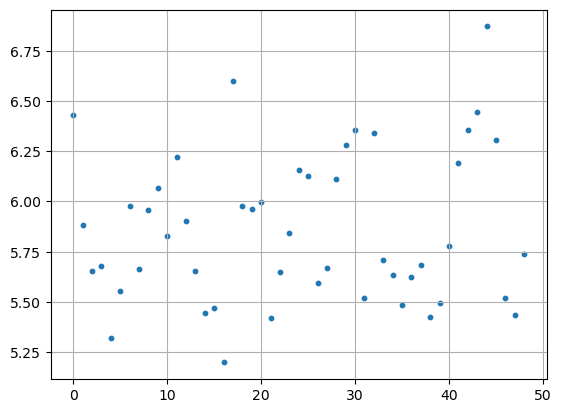

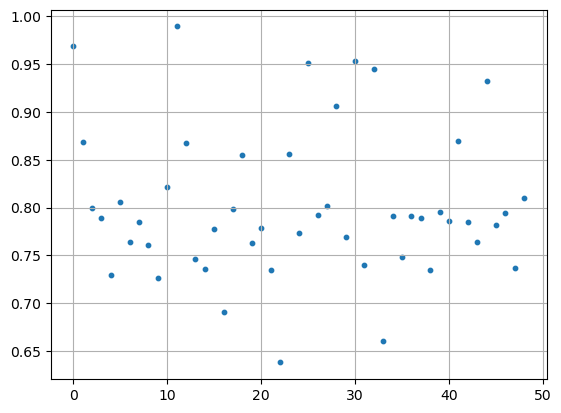

5.86177302828546 0.8010833696751898
15
[(1.51274926223188, 0.803350980632397)]
[(1.59031334487009, 0.717582338283452)]
[(1.32323057052527, 0.578938724768907)]
[(1.42046520831349, 0.684900020924944)]
[(1.86319019851531, 0.763617472923116)]
[(1.52425354222015, 0.706861631780079)]
[(1.68587894091019, 0.783469373579750)]
[(1.72297109978928, 0.798330705601360)]
[(1.69750164764131, 0.782152424558318)]
[(1.63979592385747, 0.788712823153113)]
[(1.33477880323309, 0.590611531542991)]
[(1.57183789915647, 0.739488376740046)]
[(1.44885140641114, 0.694820385762454)]
[(1.26085038004636, 0.550624521751836)]
[(1.42573759664601, 0.691170494994053)]


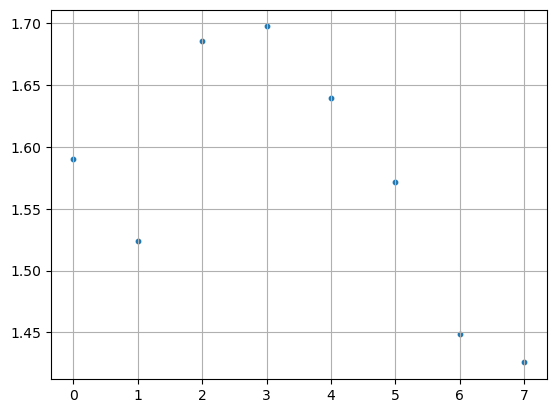

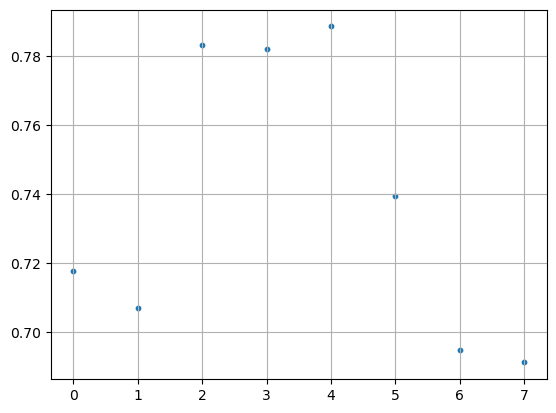

1.5730212877141028 0.738032231106408
100


KeyboardInterrupt: 

In [33]:
a = 139.5
b_list = []
c_list = []
for i in range(len(list_change) - 1):
    left = list_change[i]
    right = list_change[i + 1]
    list_combinations = list(combinations(range(left + 1, right + 1), 2)) 
    list_combinations = [list(x) for x in list_combinations]
    random.shuffle(list_combinations)
    list_solution_b = []
    n = 100
    N = min(n, len(list_combinations))
    print(N)
    for j in range(N):
         list_solution_b.append(solution_b(list_combinations[j], i))
    list_solution_b = np.array(list(filter(lambda item: item is not None, list_solution_b)))
    b_solution = pd.DataFrame(list_solution_b)
    b_solution = b_solution[(b_solution.iloc[:, 0] > 0)]
    try:
        b_solution['Cluster'] = IsolationForest(n_estimators=1000, contamination=0.5).fit_predict(standard(b_solution))
        b_solution = b_solution[b_solution['Cluster'] == 1]
        b_solution.pop('Cluster')
    except ValueError:
        pass
    plots(b_solution)
    b_list.append(b_solution.mean()[0])
    c_list.append(b_solution.mean()[1])
    print(b_solution.mean()[0], b_solution.mean()[1])

In [53]:
gf_list = [GF[list_change[i]:list_change[i + 1]].mean() for i in range(len(list_change) - 1)]
gf_list

[501.53173170731714,
 601.113,
 131.771,
 155.76992142857142,
 126.43960810810812,
 124.79418620689654,
 158.70701219512196,
 174.43875930521094,
 207.05943478260866,
 152.92936486486488]

In [54]:
w_list = [W[list_change[i]:list_change[i + 1]].mean() for i in range(len(list_change) - 1)]
w_list

[16.70731707317073,
 25.0,
 36.0,
 45.9,
 55.0,
 60.0,
 69.63414634146342,
 75.0,
 80.0,
 75.0]

In [55]:
q_list = [Q[list_change[i]:list_change[i + 1]].mean() for i in range(len(list_change) - 1)]
q_list

[391.3283018639248,
 440.413165088395,
 124.98863990337202,
 118.54542711695763,
 100.95645334714371,
 78.01930637008077,
 75.86282606603119,
 68.66579755969077,
 57.66403465401372,
 58.85325682210032]

In [56]:
p_list = [p[list_change[i]:list_change[i + 1]].mean() for i in range(len(list_change) - 1)]
p_list

[120.25609756097559,
 116.275,
 113.39999999999999,
 106.53357142857142,
 100.06,
 92.8193103448276,
 95.13780487804877,
 89.5845905707196,
 88.55652173913043,
 83.48378378378379]

In [52]:
b_list_1 = np.array(b_list).round(2)
c_list_1 = np.array(c_list).round(4)

In [243]:
b_list_1 = [4.45, 6.08, 5.88, 1.56, 0.98, 0.78, 0.52, 0.64, 0.51, 0.52, 0.4]
c_list_1 = [0.7581, 1.148 , 0.8209, 0.7429, 0.2356, 0.2415, 0.156 , 0.1807, 0.1465, 0.2038, 0.1898]

1206

In [62]:
muo = 1.284 * 10**(-3)
muw = 1.22 * 10**(-3)
m = 0.014
betao = 14.7 * 10**(-10)
beta = 0.36 * 10**(-10)
h = 53

water = np.array(w_list)/100
b = np.array(b_list_1)/(86400 * 10**5)
c = np.array(c_list_1)/86400

k = (b * muo)/h
x = k/(muo * m * (betao + beta))

r = np.sqrt(2.25 * x/c)
kw = k * water
ko = k - kw

C:\Users\SE_Nesterov\AppData\Local\Temp\ipykernel_13444\1118006742.py:15: RuntimeWarning: divide by zero encountered in true_divide
  r = np.sqrt(2.25 * x/c)


In [512]:
k * 10 ** 15

array([11.10377358, 15.14150943, 14.69287212,  3.92557652,  2.71986373,
        2.29926625,  1.62631027,  2.13102725,  5.21540881,  5.18736897,
        1.79454927])

In [59]:
b_list_1

array([3.99, 4.06, 1.04, 0.25, 0.23, 0.13, 0.16, 0.06, 0.06, 0.06])

In [60]:
c_list_1

array([5.30000e-03, 0.00000e+00, 7.07190e+00, 1.04043e+01, 1.25474e+01,
       6.57670e+00, 8.67260e+00, 5.08470e+00, 5.36980e+00, 5.21720e+00])

In [478]:
r

array([1204.31971088, 1010.00338429,  979.95714867,  514.01960387,
        482.23038591,  361.44489174,  328.03131841,  335.69532345,
        286.67761208,  255.1348495 ,  213.4535982 ])

In [255]:
k = b/h
kw = k * water
ko = k - kw

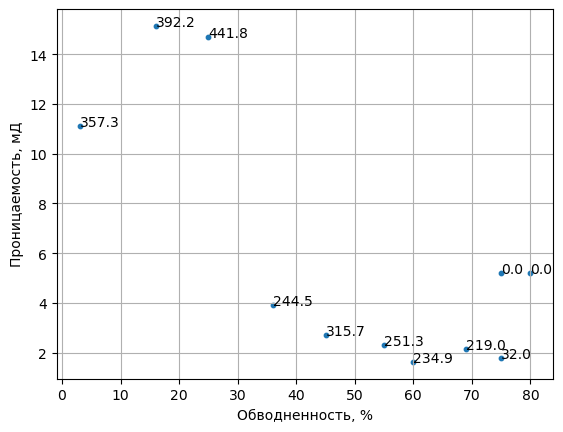

In [515]:
gf_list_1 = [int(i) for i in gf_list]
w_list_1 = [int(i) for i in w_list]
q_list_1 = [int(i) for i in q_list]
p_list_1 = [int(i) for i in p_list]
plt.scatter(w_list_1, k * 10 ** 15, s=10)
plt.xlabel('Обводненность, %')
plt.ylabel('Проницаемость, мД')
plt.grid()
for i in range(len(b_list_1)):
    plt.annotate((r[i].round(1)), (w_list_1[i], k[i] * 10 ** 15))

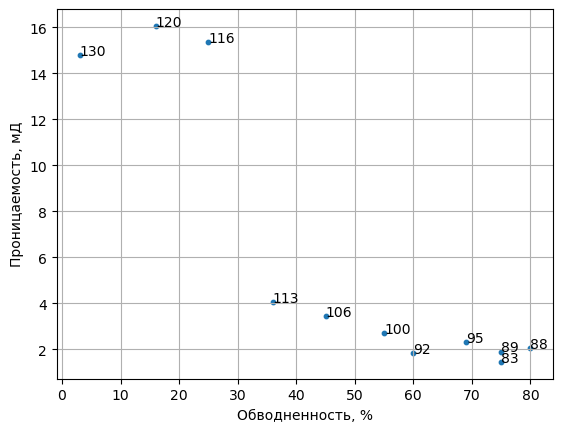

In [480]:
gf_list_1 = [int(i) for i in gf_list]
w_list_1 = [int(i) for i in w_list]
q_list_1 = [int(i) for i in q_list]
p_list_1 = [int(i) for i in p_list]
plt.scatter(w_list_1, k * 10 ** 15, s=10)
plt.xlabel('Обводненность, %')
plt.ylabel('Проницаемость, мД')
plt.grid()
for i in range(len(b_list_1)):
    plt.annotate(( p_list_1[i]), (w_list_1[i], k[i] * 10 ** 15))

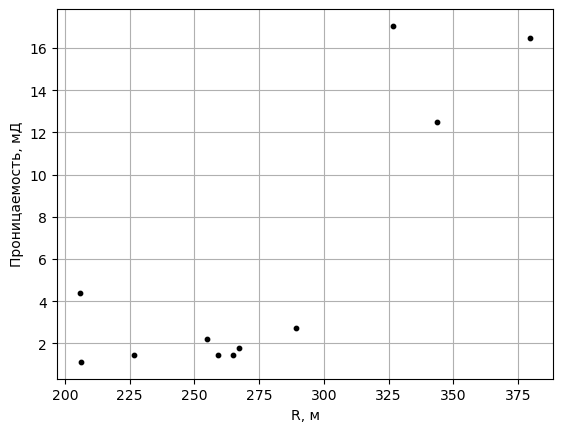

In [250]:
plt.scatter(r, k * 10 ** 15, s=10, color='black')
plt.xlabel('R, м')
plt.ylabel('Проницаемость, мД')
plt.grid()

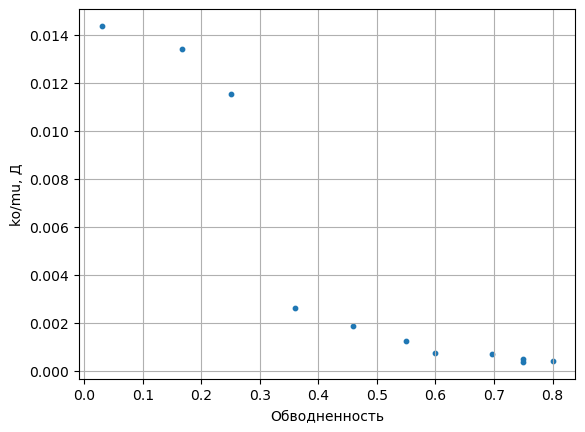

In [481]:
plt.scatter(water, ko * 10 ** 12, s=10)
plt.xlabel('Обводненность')
plt.ylabel('ko/mu, Д')
plt.grid()

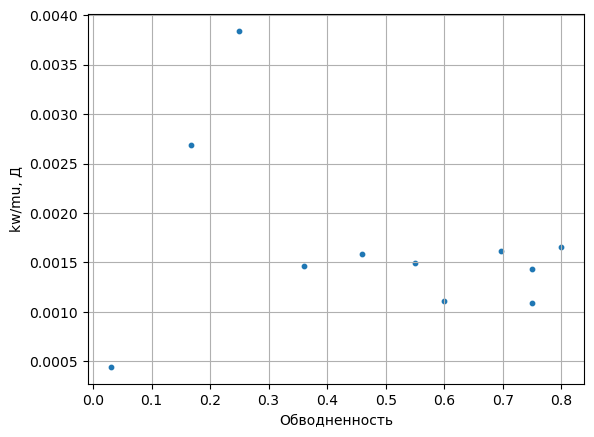

In [482]:
plt.scatter(water, kw * 10 ** 12, s=10)
plt.xlabel('Обводненность')
plt.ylabel('kw/mu, Д')
plt.grid()